In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Explore the two datasets
from sqlalchemy.orm import class_mapper
class_mapper(Measurement).columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [11]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
class_mapper(Station).columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [13]:
engine.execute('SELECT * FROM Station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


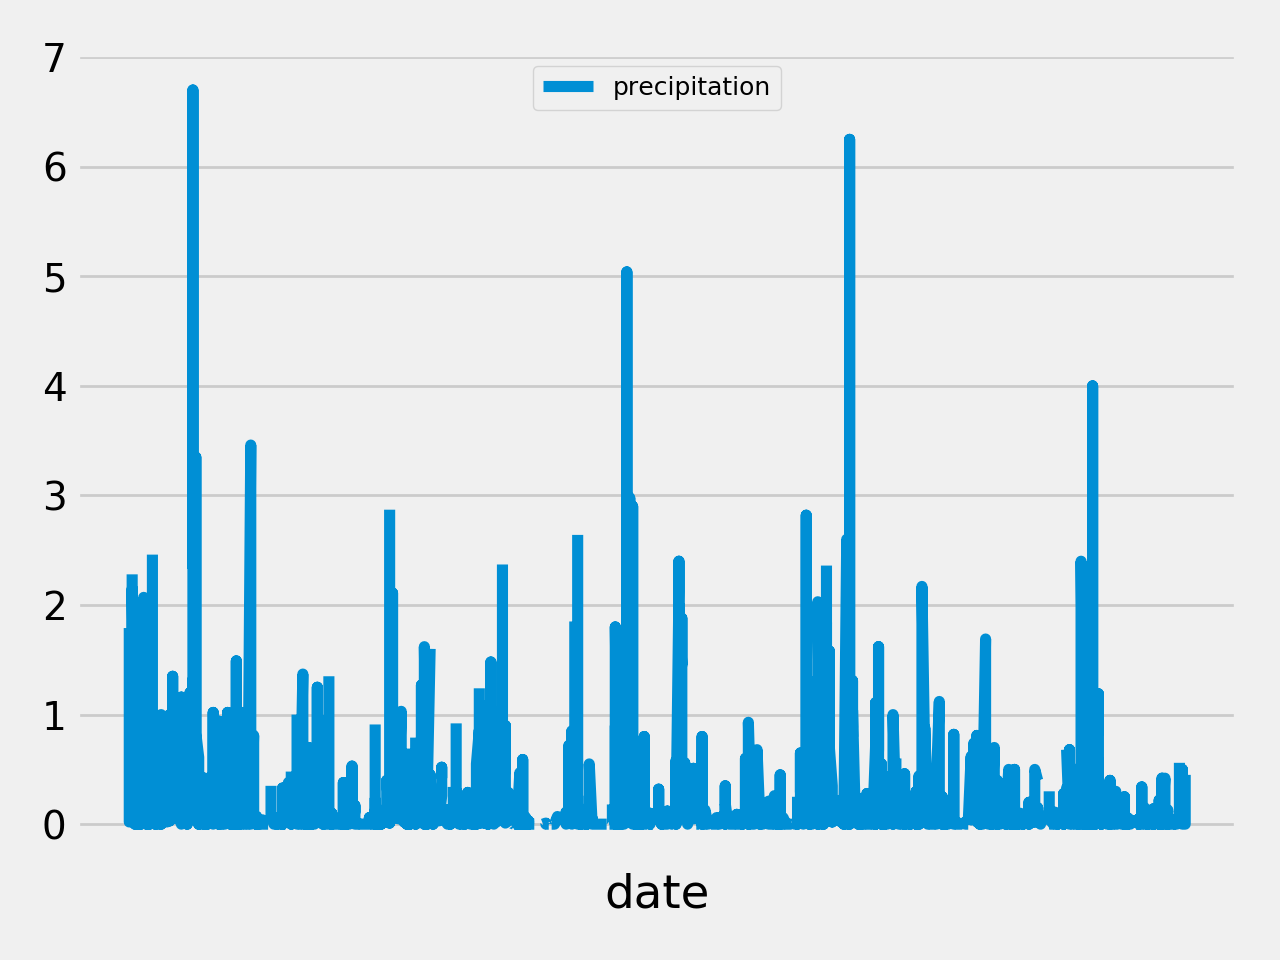

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
# Latest Date - session.query(Measurement.date).order_by(Measurement.date.desc()).first() -- '2017-08-23'
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df_sorted = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates
plt.plot(df_sorted.index, df_sorted['precipitation'], label="precipitation")
plt.legend(loc='upper center',prop={'size': 9}) 
#plt.xticks("date")
plt.xticks([])
plt.xlabel("date")

# Save the figure and show
plt.tight_layout()
plt.savefig('Images/precipitation.png')
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# How many stations are available in this dataset?
station_num = session.query(Measurement.station).distinct().count()
station_num

9

In [17]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
query = [func.min(Measurement.tobs),
         func.max(Measurement.tobs),
         func.avg(Measurement.tobs)]
session.query(*query).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


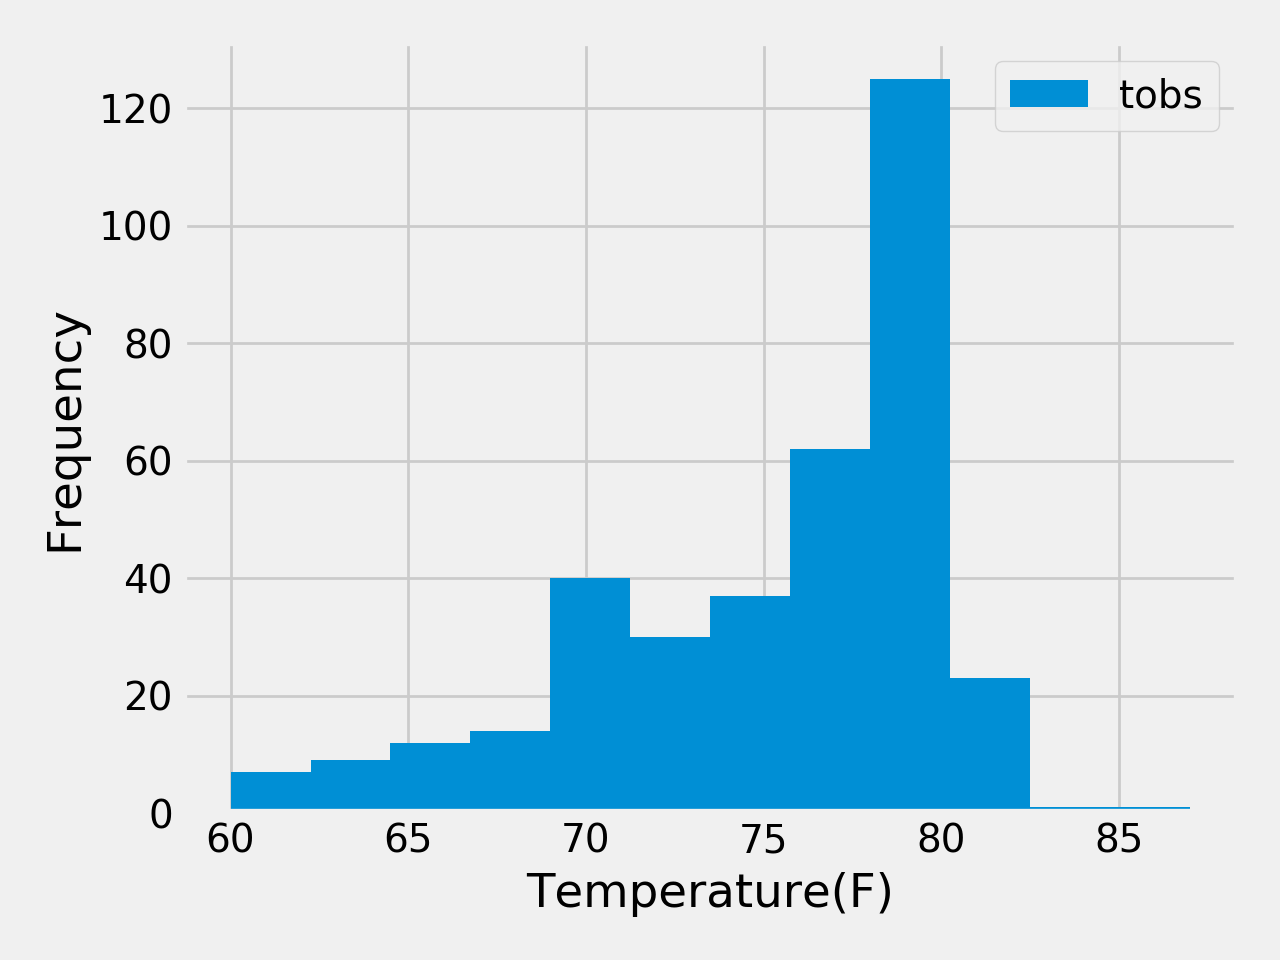

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station = session.query(Measurement.station, func.count(Measurement.station)).\
                        filter(Measurement.date >= query_date).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).first()[0]

tobs = session.query(Measurement.tobs).\
                     filter(Measurement.date >= query_date).\
                     filter(Measurement.station == station).all()

df_tobs = pd.DataFrame(tobs, columns=['tobs'])

n_bins = 12
plt.hist(df_tobs.tobs, n_bins, histtype='bar', label='tobs')

plt.xlabel("Temperature(F)")
plt.ylabel("Frequency")
plt.legend(loc='upper right')

# Save the figure and show
plt.tight_layout()
plt.savefig('Images/station-histogram.png')
plt.show()

In [20]:
# # Choose the station with the highest number of temperature observations.
# stations = session.query(Measurement.station).filter(Measurement.tobs ==
#                                                      session.query(func.max(Measurement.tobs)).first()[0]).\
#                                                      distinct().all()
# stations_list = list(np.ravel(stations))

# tobs = session.query(Measurement.tobs, func.count(Measurement.tobs)).\
#                      group_by(Measurement.tobs).\
#                      filter(Measurement.date >= query_date).\
#                      filter(Measurement.station.in_(stations_list)).all()

In [21]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date='2016-01-01'
end_date='2017-01-01'

summary = calc_temps(start_date, end_date)
summary

[(56.0, 74.1317494600432, 84.0)]

In [23]:
location= 'Honolulu, Hawaii'

df_summary = pd.DataFrame(summary, columns=['tmin','tavg','tmax'])
df_summary['location'] = location
df_summary['start_date'] = start_date
df_summary['end_date'] = end_date
df_summary['yerr'] = df_summary['tmax'] - df_summary['tmin']
df_summary = df_summary[['location','start_date','end_date','tmin','tavg','tmax','yerr']]
df_summary

,location,start_date,end_date,tmin,tavg,tmax,yerr
0,"Honolulu, Hawaii",2016-01-01,2017-01-01,56.0,74.131749,84.0,28.0


<IPython.core.display.Javascript object>


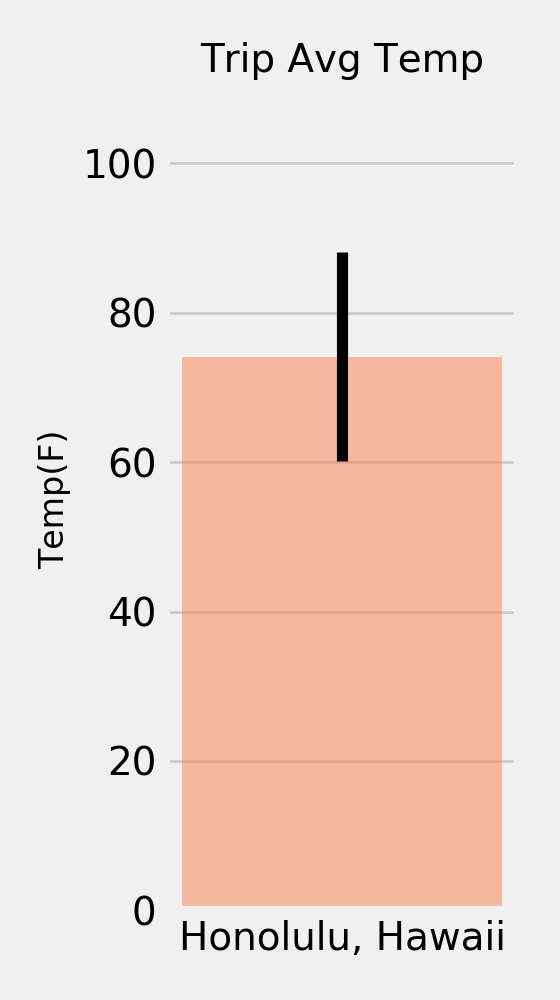

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Build the plot
fig, ax = plt.subplots(figsize=(2.8,5))
ax.bar(df_summary.location, df_summary.tavg, yerr=0.5*df_summary.yerr, align='center', alpha=0.5, color='coral',
            ecolor='black')

ax.set_title('Trip Avg Temp', fontdict = {'fontsize': 14})
ax.set_ylabel('Temp(F)', fontsize=12)
ax.set_ylim([0, 110])
ax.yaxis.grid(True)
ax.xaxis.grid(False)

# Save the figure and show
plt.tight_layout()
plt.savefig('Images/temperature.png')
plt.show()

In [25]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
              filter(Measurement.date == '2017-01-01').\
              filter(Measurement.station == Station.station).\
              order_by(Measurement.prcp.desc()).all()
rainfall

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.03),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.03),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  None)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
